# VAE Implementation

All theory is from https://arxiv.org/abs/1606.05908.

Notation:
- $X$ is a data point in our dataset
- $z$ is the latent representation of a data point
- $\theta$ is the parameters for our model, which will be a distribution for $P(X|z;\theta)$. Specifically, our model is a mapping from the latent representation to a data point.
- $D$ is our entire dataset, so $X\in D$.
<!-- 
- $f(z;\theta)$ is a map from latent variables z to a point estimate for a data point, X.)
<> - $Q(z|X)$ is a "surrogate" distribution to approximate the probability $P(z|X)$. Assuming we choose that Q(z|X) is normal, then $\mu(X;\phi)$ and $\Sigma(X;\phi)$ are the mean and variance, respectively.
-->


Explanation
- We wish to maximising the probability of our data under our model,
\begin{equation}
P(X) = \int P(X|z; \theta) P(z)dz.
\end{equation}
- When $X$ is continuous, it is common to use a normal distribution for our model:
$$P(X|z\theta) = N(f(z;\theta), \sigma^2 I).$$
Here, $f(z;\theta)$ is our point estimate for a mapping from the latent representation to the data points, i.e. $f:\mathcal{Z} \times \Theta\rightarrow \mathcal{X}$, where any $z\in \mathcal{Z}$, $\theta \in \Theta$ and $X \in \mathcal{X}$. Also, $\sigma^2$ is a hyperparameter of the model, and is set beforehand.
- We say that the samples of $z$ are from a $N(0, I)$ distribution, so $f(z; \theta)$ is left with the responsiblity of first converting these normal samples into latent variables which are more representative/useful. This uses the fact that any distribution in $d$ dimensions can be generated by taking a set of $d$ variables that are normally distributed and mapping them through a sufficiently complicated function (this is an extension of inverse transform sampling).
- To allow sufficient flexibility, $f(z;\theta)$ is usually a multi-layer neural network. This allows us to learn a map from $z\sim N(0, \sigma^2 I)$ to something which "looks like" a data point, $X$. 
- A naive approach would be to sample $z_1, ..., z_n$ for very large $n$, then approximate our model evidence as $P(X) \approx \frac{1}{n} \sum_{i=1}^n P(X|z_i; \theta)$. From here we could use gradient descent to optimise $f(z; \theta)$ by maximising $P(X)$. The problem is that in higher dimensional space, $n$ might have to be extremely large before we get an accurate estimate. This is because usually, for most $z$, $P(X|z)$ will be nearly zero. The key idea of Variational Autoencoders is to attempt to sample values of $z$ that are likely to have produced $X$, and then compute $P(X)$ just from these...
- The definition of KL-divergence is
\begin{equation}
D_{KL}(P||Q) = \int P(x) \log \left(\frac{P(x)}{Q(x)}\right)dx.
\end{equation}
Equivalently,
\begin{equation}
D_{KL}(P||Q) = \mathbb{E}_{X\sim P} \left[ \log\left(\frac{P(x)}{Q(x)}\right)\right] = \mathbb{E}_{X\sim P} \left[ \log P(x) - \log Q(x) \right].
\end{equation}
- In VAEs, we explained earlier that we want to sample the values of $z$ which are likely to have produced any particular data point, $X$. We use a "surrogate" distribution to approximate $P(z|X)$, $Q(z|X)$. Then, the KL-divergence between our surrogate distribution $Q(z|X)$ and the probability of latent variables in a particular data point, $P(z|X)$ is given by
\begin{equation*}
D_{KL}(Q(z|X) || P(z|X)) = \mathbb{E}_{z\sim Q} \left[ \log Q(z|X) - \log P(z|X) \right].
\end{equation*}
Now we can apply Bayes Rule:
\begin{align}
P(z|X) &= \frac{P(X|z) P(z)}{P(X)} \implies D_{KL}(Q(z|X) || P(z|X))\\ 
&= \mathbb{E}_{z\sim Q} \left[ \log Q(z|X) - \log \left( \frac{P(X|z) P(z)}{P(X)}\right)\right]\\
&= \mathbb{E}_{z\sim Q} \left[ \log \left( \frac{Q(z|X)}{P(z)}\right) - \log P(X|z) \right] + \log P(X)\\
&= D_{KL}(Q(z|X) || P(z)) - \mathbb{E}_{z\sim Q}\left[ \log P(X|z) \right] + \log P(X).\\
\end{align}

\begin{equation*}
\therefore \log P(X) - F_{KL}(Q(z|X) || P(z)) = \mathbb{E}_{z\sim Q}\left[ \log P(X|z)\right] - D_{KL}(Q(z|X) || P(z))
\end{equation*}

We cannot compute $D_{KL}(Q(z|X) || P(z|X))$ without knowing $P(z|X)$, but a property of KL-divergence is that it is non-negative. Therefore, our expression becomes
\begin{equation*}
\log P(X) \geq \mathbb{E}_{z\sim Q}\left[ \log P(X|z)\right] - D_{KL}(Q(z|X) || P(z)).
\end{equation*}
The LHS is called the evidence, hence the RHS is called the "Evidence Lower BOund" (ELBO). We wish to maximies the evidence (as this corresponds to the observed data being likely under our model), so in VAEs we do this by maximising the RHS and treating $D_{KL}(Q(z|X) || P(z|X))$ as an error term.
- Typically, we set our surrogate distribution as $Q(z|X) \sim N(\mu(X; \phi), \Sigma(X; \phi))$. In practice, $\mu(X; \phi)$ and $\Sigma(X;\phi)$ are again obtained using neural networks, and these are maps from a data point $X$ to the estimated mean and variance for the latent variables, respectively. Hence, the parameters $\phi$ are learned from the data. Note that $\Sigma$ is constrained to be a diagonal matrix, as independence between components is necessary for computational tractibility and encourages disentanglement of latent variables.
- In the ELBO, the term $D_{KL}(Q(z|X) || P(z))$ is a KL-divergence between multivariate Gaussian distributions, hence a closed form expression for the KL-divergence is known. In our case, 
\begin{align}
D_{KL}(Q(z|X) || P(z)) &= D_{KL}(N(\mu(X), \Sigma(X)) || N(0, I))\\
&= \frac{1}{2}\left( \text{trace}(\Sigma(X)) + (\mu(X))^T (\mu(X)) - k - \log \text{det}(\Sigma(X))\right)
\end{align}

But, in the ELBO it is more difficult to compute the term $\mathbb{E}_{z \sim Q} \left[ log P(X|z) \right]$. One approach is to estimate this expectation by sampling many $z$, although this will be expensive. Instead, we can apply the idea from stochastic gradient descent and use a single sample of $z$ to approximate this expectation for a single data point, X. Then, our total loss (over the entire dataset $D$) to minimise with stochastic gradient descent is
\begin{equation}
\mathbb{E}_{X\sim D} \left[ \mathbb{E}_{z \sim Q} \left[ \log P(X|z) \right] - D_{KL} (Q(z|X) || P(z)) \right].
\end{equation}
We estimate the gradient of this by averaging the gradient of
\begin{equation}
\log P(X|z) - D_{KL}(Q(z|X) || P(z))
\end{equation}
for an arbitrary number of samples of $z$ and $X$. The result will converge to the overall gradient (for all $X$, $z$).

- But, the issue with the above gradient estimate is that we can't actually backpropogate through $\mathbb{E}_{z\sim Q} \left[ \log P(X|z) \right]$, as the expectation $\mathbb{E}_{z \sim Q} \left[ \cdot \right]$ depends on $\phi$. Specifically, in general $\triangledown_{\phi} \mathbb{E}_{z\sim Q} \left[ \log P(X|z) \right] \neq \mathbb{E}_{z\sim Q} \left[ \triangledown_{\phi} \log P(X|z) \right]$. In integral form,
\begin{align}
\triangledown_{\phi} \mathbb{E}_{z\sim Q} \left[ \log P(X|z) \right] &= \int_z \triangledown_{\phi} ( Q(z|X) \log P(X|z) ) dz\\
&= \int_z \triangledown_{\phi} (Q(z|X)) \log P(X|z)dz + \int_z Q(z|X) \triangledown_{\phi} ( \log P(X|z) ) dz\\
&= \int_z \triangledown_{\phi} (Q(z|X)) \log P(X|z)dz + \mathbb{E}_{z \sim Q} \left[ \triangledown_{\phi} (\log P(X|z) ) \right].
\end{align}

We get around this issue using the reparametrisation trick. We instead convert the random sampling into a (stochastic) input, and then write $Q(z|X)$ as a deterministic function of these stochastic inputs. For example, when $Q(z|X)\sim N(\mu(X; \phi), \Sigma(X; \phi))$ can be written as 
$$Q(z|X) = \mu(X; \phi) + (\Sigma(X; \phi))^{\frac{1}{2}} \cdot \epsilon,$$ 
where $\epsilon \sim N(0, I)$. In general, we want to sample from $Q(z|X)$ by evaluating a function $h(\nu, X)$, where $\nu$ is noise from a distribution that is not learned (i.e. has fixed inputs that don't depend on $\phi$). Also, $h$ must be continuous in $X$ so that we can backpropogate through it. 

Things to estimate in VAE:
- $f(z; \theta)$, neural network. Maps $z$ to $X$.
- $\mu(X; \phi)$ and $\Sigma(X; \phi)$, neural network. Parameters of the surrogate $Q(z|X)$ for $P(z|X)$. $\mu$ maps the data point $X$ to a point estimate of the mean for the latent variables $z$, and $\Sigma$ maps $X$ to the estimated variance for $z$.



We will first apply to the MNIST Dataset.

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch import nn



transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1] range
])




batch_size = 64  # You can change this

# Load training dataset
train_dataset = torchvision.datasets.MNIST(
    root="./data", train=True, transform=transform, download=True
)

# Load test dataset
test_dataset = torchvision.datasets.MNIST(
    root="./data", train=False, transform=transform, download=True
)

# Create DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


ModuleNotFoundError: No module named 'torch'

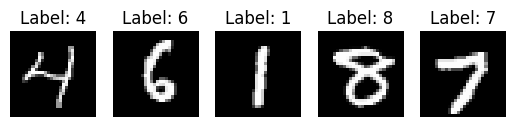

In [ ]:
import matplotlib.pyplot as plt

# Get a batch of images
images, labels = next(iter(train_loader))

# Plot first 5 images
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i].squeeze(), cmap="gray")
    plt.title(f"Label: {labels[i].item()}")
    plt.axis("off")

plt.show()


## VAE Implementation

Things to do:
- train neural network for $f(z; \theta)$. But, do we want to use the error term to select hyperparameters??
-

In [ ]:
#Functions necessary to train and validate VAE

def train_VAE(train_dataloader):
  """
  Function to train the VAE.

  Inputs:
  - train_dataloader: the `DataLoader` object for the training dataset.
  """

  return None



def evaluate_VAE(test_dataloader):
  """
  Function to evaluate the VAE.

  Inputs:
  - test_dataloader: the `DataLoader` object for the test dataset.
  """

  return None



def train_f(z, sigma):
  """
  Function to learn the function f(z; theta), which maps latent representations
  to data points.

  Inputs:
  - z: the input latent representation.
  - sigma: this is the

  Outputs:
  - f: the learned function from latent representations to data points.
  """

  f = None

  return f



class prob_X_given_z_loss(nn.module):
  """
  Custom loss function to train f(z; theta)
  """

  def __init__(self):
    super(prob_X_given_z_loss, self).__init__()

  def forward(self, X, f_z, sigma):
    """
    Function to calculate negative likelihood, -P(X|z) = N(X|f(z; theta), sigma^2*I).

    Inputs:
    - X: the batch of data points to be evaluated.
    - f_z: the function f(z; theta), evaluated at the



    HOW DO WE KNOW THE z CORRESPONDING TO SOME X?

    ^Should end up with MSE - revise deep learning textbook example.

    ^Issue is that we have an extra layer of randomness compared to textbook example,
    as we don't know the z corresponding to each data point and therefore cannot
    compute f(z; theta) for the z corresponding to a particular X.

    Instead, can we integrate over all possible z? Although this will be very
    expensive for a loss function.

    Or, the ide acould just be to sample one z and then use this? No, this
    won't encourage continuity...


    ^NEED TO TRAIN FOR THETA AND PHI AT THE SAME TIME! CHANGE IPAD NOTES!




    """

    # Define multivariate normal distribution
    mvn = torch.distributions.MultivariateNormal(f_z, covariance_matrix=sigma^2 * torch.eye(len(f_z)))

    # Evaluate PDF at specific points
    x = torch.tensor([[0.0, 0.0], [1.0, 1.0], [-1.0, -1.0]])  # 3 points in 2D space
    pdf_values = mvn.log_prob(x).exp()  # Compute PDF

    normal_dist = torch.distributions.Normal(f_z, sigma)

    # Compute density for a given x value
    x = torch.tensor([0.0, 1.0, -1.0, 2.0])  # Points to evaluate
    pdf_values = normal_dist.log_prob(x).exp()  # Compute PDF

    likelihood =



## Notes

- Will use $P(X|z) = N(X|f(z; \theta), \sigma^2 * I)$ for a loss function. We wish to maximise this, or equivalently to minimise $-P(X|z)$.